In [ ]:
! ls -l data/Fruit-Images-Dataset-master/Test/ | head -5

In [ ]:
#! wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
#! mv 101_ObjectCategories.tar.gz data/

In [ ]:
! mv 101_ObjectCategories/ data/

In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from  scipy import ndimage
from keras.preprocessing import image

/home/siddb/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
base_img_dir = "data/101_ObjectCategories/"
image_files = glob(base_img_dir + '/*/*.jpg')

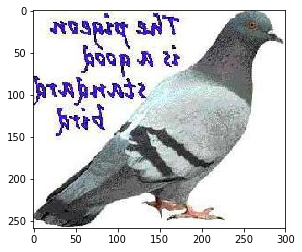

In [4]:
# look at an image for fun
plt.ion()
plt.imshow(Image.open(np.random.choice(image_files)))
plt.show()

In [41]:
device = torch.device("cpu") 
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    device = torch.device("cuda")

Using CUDA


In [42]:
resnet50 = models.resnet50(pretrained=True)
#print(resnet50)

In [43]:
if use_gpu:
    resnet50 = resnet50.cuda()

#Freeze training for all layers
for param in resnet50.parameters():
    param.require_grad = False

#resnet50.eval()
# get the feature map weights
final_dense = resnet50.fc
#print(final_dense)
W = final_dense.weight
#print(W.size())
#W = final_dense.get_weights()[0]    

#modified resnet50
layers = list(resnet50.children())[:-2]
resnet50_fmap = nn.Sequential(*layers)
#print(resnet50_fmap)

if use_gpu:
    resnet50_fmap=resnet50_fmap.cuda()
#activation_layer = resnet50.layer4[2].relu
#activation_layer = resnet.get_layer('activation_49')
resnet50.eval()
resnet50_fmap.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [44]:
print(W.size())
print(W[2, :])

torch.Size([1000, 2048])
tensor([-0.0072,  0.0664, -0.0393,  ...,  0.0130, -0.0249, -0.0015],
       device='cuda:0', grad_fn=<SelectBackward>)


In [45]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               normalize])  

In [46]:
# ! wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
import json
class_idx = json.load(open("imagenet_class_index.json"))
#print(class_idx)


In [47]:
def getCAM(feature_conv, weight):
    _, nc, h, w = feature_conv.shape
    cam = weight.dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

Probs: torch.Size([1, 1000])
tensor([600], device='cuda:0')
tensor([600])
(2048,) (1, 2048, 7, 7)


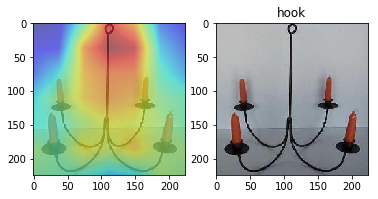

Continue? (Y/n)Y
Probs: torch.Size([1, 1000])
tensor([406], device='cuda:0')
tensor([406])
(2048,) (1, 2048, 7, 7)


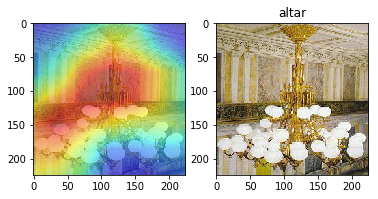

Continue? (Y/n)Y
Probs: torch.Size([1, 1000])
tensor([130], device='cuda:0')
tensor([130])
(2048,) (1, 2048, 7, 7)


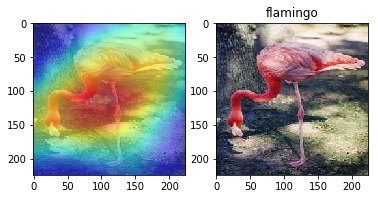

Continue? (Y/n)Y
Probs: torch.Size([1, 1000])
tensor([777], device='cuda:0')
tensor([777])
(2048,) (1, 2048, 7, 7)


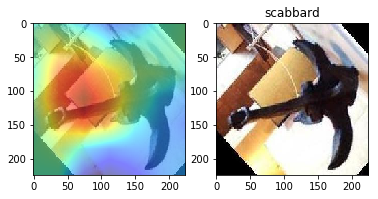

In [ ]:
with torch.no_grad():
    while True:
        img = image.load_img(np.random.choice(image_files), target_size=(224, 224))
        x = transform(img).unsqueeze(0)
        #print(img.size())
        if use_gpu:
            x = x.cuda()
        fmaps = resnet50_fmap(x)
        probs = resnet50(x)
        print("Probs:", probs.size())
        _, pred = torch.max(probs, 1)
        print(pred)
        #classnames = decode_predictions(probs)[0]
        #print(classnames)
        print(pred.cpu().data)
        classname = class_idx[str(pred.cpu().item())][1]
        w_updated = W.detach().cpu().numpy()
        fmaps_updated = fmaps.detach().cpu().numpy()
        w = w_updated[pred]

        print(w.shape, fmaps_updated.shape)
        
        cam_img = getCAM(fmaps, w)
        cam = ndimage.zoom(cam_img[0], (32, 32), order=1)
        plt.subplot(1,2,1)
        plt.imshow(img, alpha=0.8)
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.subplot(1,2,2)
        plt.imshow(img)
        plt.title(classname)
        plt.show()
        
        ans = input("Continue? (Y/n)")
        if ans and ans[0].lower() == 'n':
            break